In [102]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
mpl.rcParams['timezone'] = 'Europe/Moscow'
import pickle
import numpy as np
import json
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
from bot.utils.files import load_config

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.pair_trading import *
from bot.utils.data import calculate_profit
from bot.core.exchange.trade_api import Trade

In [103]:
with open("./data/coin_information.pkl", "rb") as f:
     coin_information = pickle.load(f)

In [104]:
def switch_pairs(mode, old_token, new_token, keep_token, coin_information, db_manager):
    demo = True if mode == 'demo' else False
    trade_manager = Trade(demo=demo)
    ps = coin_information['bybit_linear'][new_token]['price_scale']
    qty_step = coin_information['bybit_linear'][new_token]['qty_step']
    
    current_pairs = db_manager.get_table('pairs', df_type='polars')
    curr_pair = current_pairs.filter((pl.col('token_1') == old_token) | (pl.col('token_2') == old_token))
    curr_prices = db_manager.get_table('current_ob', df_type='polars')

    curr_pos_side = curr_pair.select(
            pl.when(pl.col('token_1') == old_token).then(pl.col('side_1')).otherwise(pl.col('side_2'))
        ).item()
    qty_to_close = curr_pair.select(
            pl.when(pl.col('token_1') == old_token).then(pl.col('qty_1')).otherwise(pl.col('qty_2'))
        ).item()
    qty_to_keep = curr_pair.select(
            pl.when(pl.col('token_1') == keep_token).then(pl.col('qty_1')).otherwise(pl.col('qty_2'))
        ).item()

    close_price_col = 'bid_price_0' if curr_pos_side == 'long' else 'ask_price_0'
    open_price_col = 'bid_price_0' if curr_pos_side == 'short' else 'ask_price_0'

    close_price = curr_prices.filter(pl.col('token') == old_token).select(close_price_col).item()
    open_price = curr_prices.filter(pl.col('token') == new_token).select(open_price_col).item()
    keep_token_price = curr_prices.filter(pl.col('token') == keep_token).select(open_price_col).item()

    pos_size_to_hedge = round(qty_to_keep * keep_token_price, 8)
    new_size = round_down(pos_size_to_hedge / open_price, qty_step)

    leverage = curr_pair['leverage'].item()
    sl = round(open_price - 0.8 * open_price / leverage, ps) if curr_pos_side == 'long' else round(open_price + 0.8 * open_price / leverage, ps)

    act_old = 'Sell' if curr_pos_side == 'long' else 'Buy'
    act_new = 'Sell' if curr_pos_side == 'short' else 'Buy'
    
    rsp = trade_manager.place_pair_order('linear', old_token, act_old, qty_to_close, None, new_token, act_new, new_size, sl)
    for r in rsp:
        res = trade_manager.get_order('linear', order_id=r)
        if res['token'] == old_token:
            close_price = res['price']
            close_fee = res['fee']
    
    token_1 = curr_pair['token_1'].item()
    token_2 = curr_pair['token_2'].item()

    usdt_amount = open_price * new_size / leverage
    
    db_manager.complete_half_order(token_1, token_2, old_token, close_price, close_fee)
    db_manager.switch_order(old_token, new_token, new_size, open_price, usdt_amount)
    
    print(f'Меняем токен {qty_to_close} {old_token} (цена: {close_price}) на {new_size} {new_token} (цена: {open_price}).')
    print(f'Позиция {old_token}: {curr_pos_side}')
    print(f'Стоимость позиции {qty_to_keep} {keep_token}: {pos_size_to_hedge} (Цена: {keep_token_price})')

    print(f'Действие: {act_old} {qty_to_close} {old_token}; {act_new} {new_size} {new_token}')

In [105]:
def create_spread_hist_df(token_1, token_2, min_order, method, curr_order, hours_back):
    curr_order = orders.filter(
        (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2)
    ).tail(1)

    tf = curr_order['tf'][0]
    wind = curr_order['wind'][0]
    train_len = int(tf[0]) * wind * 2

    ct = curr_order['ct'][0]
    st_time = datetime.strptime(ct, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
    valid_time = st_time - timedelta(hours = hours_back)
    start_time = valid_time - timedelta(hours = train_len)
    thresh_in = curr_order['thresh_in'][0]
    thresh_out = curr_order['thresh_out'][0]
    side = curr_order['side'][0]

    df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time)
    df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time)

    df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time,
                             )

    if tf == '1h':
        agg_df = make_trunc_df(df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')[:-1]
    elif tf == '4h':
        agg_df = make_trunc_df(df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')[:-1]
    else:
        raise NotImplementedError('Введите верный таймфрейм ("1h", "4h")')

    df_sec = make_trunc_df(df, timeframe='1s', token_1=token_1, token_2=token_2, start_date=valid_time, method='last', return_bid_ask=True)

    result_df = create_zscore_df(token_1, token_2, df_sec, agg_df, np.array((wind,)), method, min_order)

    result_df = result_df.select('time', token_1, token_2, f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'beta_{wind}', f'z_score_{wind}').rename(
        {f'beta_{wind}': 'beta', f'z_score_{wind}': 'z_score'}
                    )
    return result_df

In [106]:
def plot_graphs(current_pairs, thr_in, thr_out):
    for row in current_pairs.iter_rows(named=True):
        token_1 = row['token_1']
        token_2 = row['token_2']
        side = row['side_1']
        t1_name = token_1[:-5]
        t2_name = token_2[:-5]
        open_time = row['created_at']

        tf = '4h'
        wind = 24

        start_ts = int(datetime.timestamp(open_time))
        end_ts = int(datetime.timestamp(datetime.now()))
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)

        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)

        fig, ax1 = plt.subplots(figsize=(14, 3))

        # График z_score
        ax1.plot(hist.select('time'), hist.select(f'z_score'), color='blue', label='z_score', ls='-', lw=1)
        ax1.plot(hist.select('time'), hist.select(f'fixed_z_score'), color='gray', label='fixed z_score', ls='-', lw=1)
        ax1.set_title(f'{token_1[:-5]} - {token_2[:-5]} ({side}; tf: {tf}; wind: {wind}). z_score: {curr_zscore}; profit: {curr_profit}')

        ax1.set_ylabel('z_score')

        if side == 'long':
            ax1.axhline(-thr_in, c='g', linestyle='dotted')
            ax1.axhline(thr_out, c='r', linestyle='dotted')
        else:
            ax1.axhline(thr_in, c='g', linestyle='dotted')
            ax1.axhline(-thr_out, c='r', linestyle='dotted')

        # График профита
        ax2 = ax1.twinx()
        ax2.plot(hist.select('time'), hist.select('profit'), color='green', label='profit', lw=2.0)
        ax2.set_ylabel('profit')
        ax2.grid()
        plt.tight_layout()
        fig.legend(loc='upper right', bbox_to_anchor=(0.135, 0.9))
        plt.show()

In [150]:
config = load_config('./bot/config/config.yaml')
current_pairs = db_manager.get_table('pairs', df_type='polars')

tf = config['tf']
wind = config['wind']
thr_in = config['thresh_in']
thr_out = config['thresh_out']

current_profit = 0

for row in current_pairs.iter_rows(named=True):
    token_1 = row['token_1']
    token_2 = row['token_2']
    side = row['side_1']
    t1_name = token_1[:-5]
    t2_name = token_2[:-5]
    open_time = row['created_at']

    end_ts = int(datetime.timestamp(datetime.now()))
    start_ts = end_ts - 30

    try:
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)
        curr_zscore = round(hist[-1]['z_score'][0], 2)
        fix_zscore = round(hist[-1]['fixed_z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)
        current_profit += curr_profit
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} (wind: {wind:>2}): z_score: {curr_zscore:5}; z_score fix: {fix_zscore:5}; profit: {curr_profit:5}')
    except IndexError:
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} (wind: {wind:>2}): z_score: NaN; fix_zscore: NaN; profit: NaN')

print(f'{" "*49} current_profit: {current_profit:.2f}')

  ONDO - OP     (wind: 64): z_score: -2.87; z_score fix: -5.57; profit: -3.63
   IMX - XTZ    (wind: 64): z_score:  -1.5; z_score fix: -1.91; profit: -1.35
  AERO - LDO    (wind: 64): z_score:  1.85; z_score fix:  2.42; profit:  -2.0
                                                  current_profit: -6.98


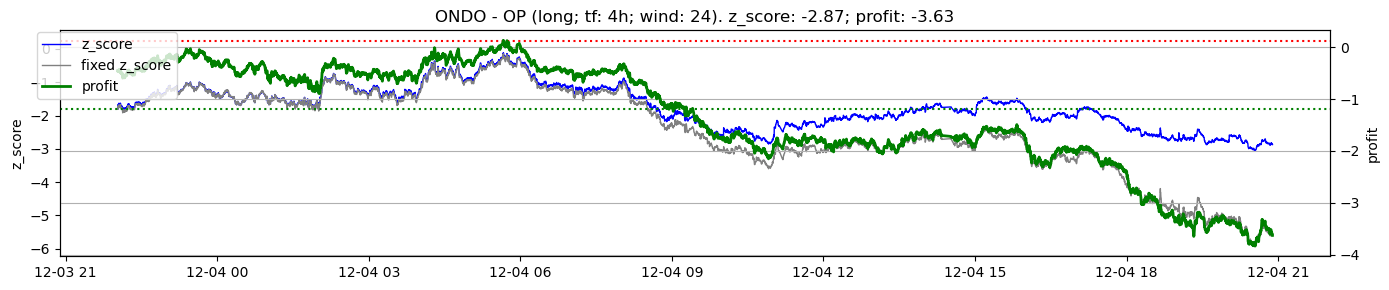

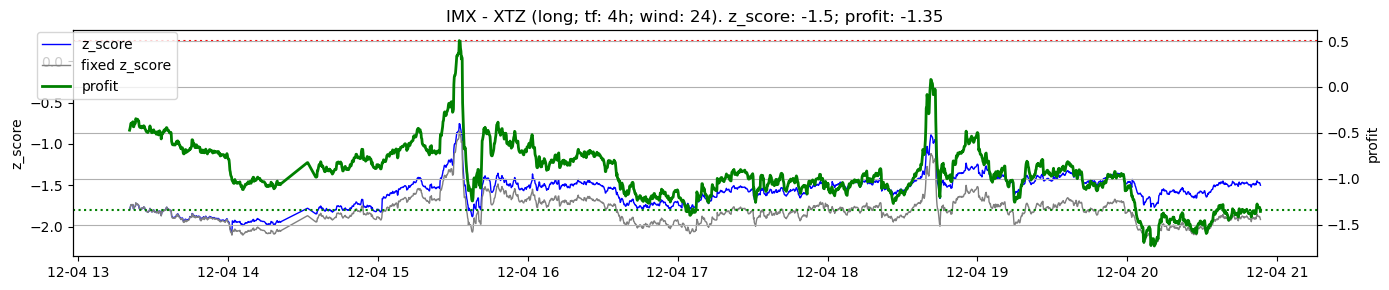

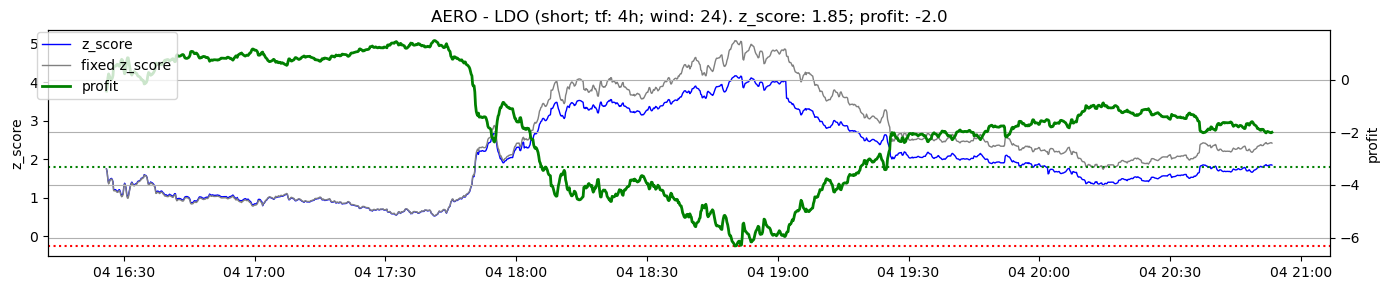

In [151]:
plot_graphs(current_pairs, thr_in, thr_out)

In [109]:
# Убрать из токенов для торговли: ARKM - MANTA; ARKM - SEI

In [9]:
token_1 = 'AERO_USDT'
token_2 = 'LDO_USDT'
side_1 = 'short'

# db_manager.add_pair_to_stop_list(token_1, token_2)
# db_manager.close_pair_order(token_1, token_2, side_1, 'manual')

In [16]:
def create_report(token_1, token_2):
    config = load_config('./bot/config/config.yaml')
    tf = config['tf']
    wind = config['wind']
    min_order = config['min_order']
    
    pair = db_manager.get_table('pairs', df_type='polars').filter(pl.col('token_1') == token_1 + '_USDT')
    open_time = pair['created_at'][0]
    end_time = datetime.now()
    start_ts = int(datetime.timestamp(open_time))
    end_ts = int(datetime.timestamp(end_time))
    hist_zscore = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', start_ts, end_ts)
    hist_zscore = hist_zscore.with_columns(
            pl.rolling_corr(
                a="profit",
                b="z_score",
                window_size=72000,
                min_samples=60,
                ddof=1
            ).alias("corr")
        )
    
    tick_df, agg_df = load_data(token_1, token_2, open_time, end_time, tf, wind, db_manager)
    tick_df = tick_df.with_columns((pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread'))
    agg_df = agg_df.with_columns((pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread'))

    dist_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, np.array([wind]), start_ts, 
                             median_length=6, spr_method='dist')
    lr_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, np.array([wind]), start_ts, 
                             median_length=6, spr_method='lr')
    tls_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, np.array([wind]), start_ts, 
                             median_length=6, spr_method='tls')

    lr_spread = lr_df[f'spread_{wind}_{tf}'].to_numpy()

    side_1 = pair['side_1'][0]
    side_2 = pair['side_2'][0]
    profit = hist_zscore['profit'][-1]
    start_zscore = hist_zscore['z_score'][0]
    z_score = hist_zscore['z_score'][-1]
    fixed_z_score = hist_zscore['fixed_z_score'][-1]
    
    curr_df = agg_df.vstack(tick_df.select('time', 'ts', token_1, token_2, 'log_spread').tail(1))
    current_rsi_1h = rsi(curr_df, window=14, col_name='log_spread').filter(pl.col('time') > open_time)

    current_5m = make_trunc_df(tick_df, '5m', token_1, token_2, method="triple").with_columns(
            (pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread')
        )
    current_rsi_5m = rsi(current_5m, window=24, col_name='log_spread').filter(pl.col('time') > open_time)

    params = {'tf': tf, 'wind': wind, 'side_1': side_1, 'side_2': side_2}
    open_time_stats = get_open_time_stats(token_1, token_2, open_time, tick_df, agg_df, lr_spread, params, coin_information)
    
    mean_wind = open_time_stats['mean_wind']
    mean_12h = open_time_stats['mean_12h']
    mean_diff = open_time_stats['mean_diff']
    std_1_180d = open_time_stats['std_1_180d']
    std_2_180d = open_time_stats['std_2_180d']
    std_1_wind = open_time_stats['std_1_wind']
    std_2_wind = open_time_stats['std_2_wind']
    std_1_12h = open_time_stats['std_1_12h']
    std_2_12h = open_time_stats['std_2_12h']
    coint = open_time_stats['coint_180d']
    hedge_r = open_time_stats['johansen_beta_180d']
    beta_1_180d = open_time_stats['beta_1_180d']
    beta_2_180d = open_time_stats['beta_2_180d']
    pv_1_180d = open_time_stats['pv_1']
    pv_2_180d = open_time_stats['pv_2']
    tls_beta_180d = open_time_stats['tls_beta_180d']
    tls_beta_wind = open_time_stats['tls_beta_wind']
    tls_beta_12h = open_time_stats['tls_beta_12h']
    hurst_wind = open_time_stats['hurst_wind']
    hurst_12h = open_time_stats['hurst_12h']
    trend_wind = open_time_stats['trend_wind']
    trend_12h = open_time_stats['trend_12h']
    spread_rsi_5m = open_time_stats['spread_rsi_5m']
    spread_rsi_1h = open_time_stats['spread_rsi_1h']
    rsi_t1_5m = open_time_stats['rsi_t1_5m']
    rsi_t2_5m = open_time_stats['rsi_t2_5m']
    rsi_t1_1h = open_time_stats['rsi_t1_1h']
    rsi_t2_1h = open_time_stats['rsi_t2_1h']
    rel_mean_12 = open_time_stats['profit_sensitivity_12h_mean']
    rel_pos_12 = open_time_stats['profit_sensitivity_12h_pos']
    rel_neg_12 = open_time_stats['profit_sensitivity_12h_neg']
    rel_mean_w = open_time_stats['profit_sensitivity_wind_mean']
    rel_pos_w = open_time_stats['profit_sensitivity_wind_pos']
    rel_neg_w = open_time_stats['profit_sensitivity_wind_neg']
    half_life_log_spread = open_time_stats['half_life_log_spread']
    half_life_lr_spread = open_time_stats['half_life_lr_spread']

    
    print(f'{token_1} - {token_2} ({side_1}, {tf=}, {wind=})')
    print(f'[ OPEN] Время: {open_time:%Y-%m-%d %H:%M:%S}; z_score: {start_zscore:.2f}')
    print(f'Mean: ({wind}h) {mean_wind:.4f}; (12h) {mean_12h:.4f}; diff: {mean_diff:.2f}%')
    print(f'Std: (180d) {std_1_180d:.4f} / {std_2_180d:.4f}; ({wind}h) {std_1_wind:.4f} / {std_2_wind:.4f}', end='; ')
    print(f'(12h) {std_1_12h:.4f} / {std_2_12h:.4f};')
    print(f'Std_ratio: (180d) {std_1_180d / std_2_180d:.4f}; ({wind}h) {std_1_wind / std_2_wind:.4f}; (12h) {std_1_12h / std_2_12h:.4f}')
    print(f'Коинтеграция. coint: {coint}; joh. beta_180d: {hedge_r:.2f}; p_value_1: {pv_1_180d:.2f}, p_value_2: {pv_2_180d:.2f}')
    print(f'Коэф. хеджирования (180d): beta_1: {beta_1_180d:.3f}, beta_2: {beta_2_180d:.3f}; tls_beta: {tls_beta_180d:.3f}')
    print(f'Tls beta: ({wind}h) {tls_beta_wind:.2f}; (12h) {tls_beta_12h:.2f}')
    print(f'Hurst Exp: ({wind}h) {hurst_wind:.2f}; (12h) {hurst_12h:.2f}')
    print(f'Half-life: (log spread) {half_life_log_spread:.1f} hours; (LinReg spread) {half_life_lr_spread:.1f}')
    print(f'LinReg: ({wind}h) {trend_wind:.1f}%; (12h) {trend_12h:.1f}%')
    print(f'RSI. Spread: (5m) {spread_rsi_5m:.1f}, (1h) {spread_rsi_1h:.1f}', end='; ')
    print(f'{token_1}: (5m) {rsi_t1_5m:.1f}, (1h) {rsi_t1_1h:.1f}', end='; ')
    print(f'{token_2}: (5m) {rsi_t2_5m:.1f}, (1h) {rsi_t2_1h:.1f}')
    print(f'Сила движения профита отн. z_score: ({wind}h) mean: {rel_mean_w:.4f}, pos: {rel_pos_w:.4f}, neg: {rel_neg_w:.4f}')
    print(f'(12h) mean: {rel_mean_12:.4f}, pos: {rel_pos_12:.4f}, neg: {rel_neg_12:.4f}')
    
    print()
    print(f'[ NOW ] z_score: {z_score:.2f}; fixed z_score: {fixed_z_score:.2f}; profit: {profit:.2f}; ')

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(4, 3, height_ratios=[2, 3, 2, 2], width_ratios=[1, 1, 1])

    # ----- График профита -----
    ax0 = fig.add_subplot(gs[0, :])  
    ax0.plot(hist_zscore['time'], hist_zscore['profit'], c='green', linewidth=2)
    ax0.grid()
    ax0.set_title(f'Profit')
    
    # ----- График z_score -----
    ax1 = fig.add_subplot(gs[1, :])  
    ax1.plot(dist_df['time'], dist_df[f'z_score_{wind}_{tf}'], c='green', label='dist')
    ax1.plot(lr_df['time'], lr_df[f'z_score_{wind}_{tf}'], c='blue', label='lr')
    ax1.plot(tls_df['time'], tls_df[f'z_score_{wind}_{tf}'], c='red', label='tls')
    ax1.plot(hist_zscore['time'], hist_zscore['fixed_z_score'], c='gray', label='fixed', linewidth=2)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    if side_1 == 'long':
        ax1.axhline(y=-2.25, color='green', linestyle='--', linewidth=1)
        ax1.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    else:
        ax1.axhline(y=2.25, color='green', linestyle='--', linewidth=1)
        ax1.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    
    ax1.grid()
    ax1.set_title(f'z_score')
    ax1.legend()

    
    # ----- График среднего значения спреда и отклонения -----
    ax2 = fig.add_subplot(gs[2, 0])  
    ax2.plot(dist_df['time'], dist_df[f'spread_mean_{wind}_{tf}'], c='blue')
    ax2.set_title('Spread mean')
    ax2.grid();

    ax3 = fig.add_subplot(gs[2, 1])  
    ax3.plot(dist_df['time'], dist_df[f'spread_std_{wind}_{tf}'], c='blue')
    ax3.set_title('Spread std')
    ax3.grid();

    ax4 = fig.add_subplot(gs[2, 2])  
    ax4.plot(hist_zscore['time'], hist_zscore[f'corr'], c='blue')
    ax4.set_title('Correlation')
    ax4.grid();

    ax5 = fig.add_subplot(gs[3, :])
    ax5.plot(current_rsi_5m['time'], current_rsi_5m['rsi'], c='red', label='5m')
    ax5.plot(current_rsi_1h['time'], current_rsi_1h['rsi'], c='green', label='1h')
    ax5.grid();
    ax5.legend()

    
    
    plt.tight_layout()
    plt.show()

    
    return tick_df, agg_df, hist_zscore, lr_df

INJ - PENDLE (short, tf='1h', wind=64)
[ OPEN] Время: 2025-12-04 09:06:55; z_score: 1.79
Mean: (64h) 0.7761; (12h) 0.7958; diff: 2.54%
Std: (180d) 0.0564 / 0.0543; (64h) 0.0083 / 0.0087; (12h) 0.0042 / 0.0071;
Std_ratio: (180d) 1.0385; (64h) 0.9475; (12h) 0.5922
Коинтеграция. coint: 0; joh. beta_180d: 1.50; p_value_1: 0.43, p_value_2: 0.28
Коэф. хеджирования (180d): beta_1: 0.721, beta_2: 1.213; tls_beta: 1.193
Tls beta: (64h) 0.68; (12h) 3.18
Hurst Exp: (64h) 0.55; (12h) 0.61
Half-life: (log spread) 9.0 hours; (LinReg spread) 0.6
LinReg: (64h) 8.7%; (12h) 0.6%
RSI. Spread: (5m) 68.7, (1h) 63.7; INJ: (5m) 51.8, (1h) 61.5; PENDLE: (5m) 34.5, (1h) 48.3
Сила движения профита отн. z_score: (64h) mean: -1.1616, pos: -1.2794, neg: -1.0431
(12h) mean: -1.0577, pos: -1.1002, neg: -1.0150

[ NOW ] z_score: 1.96; fixed z_score: 2.20; profit: -1.30; 


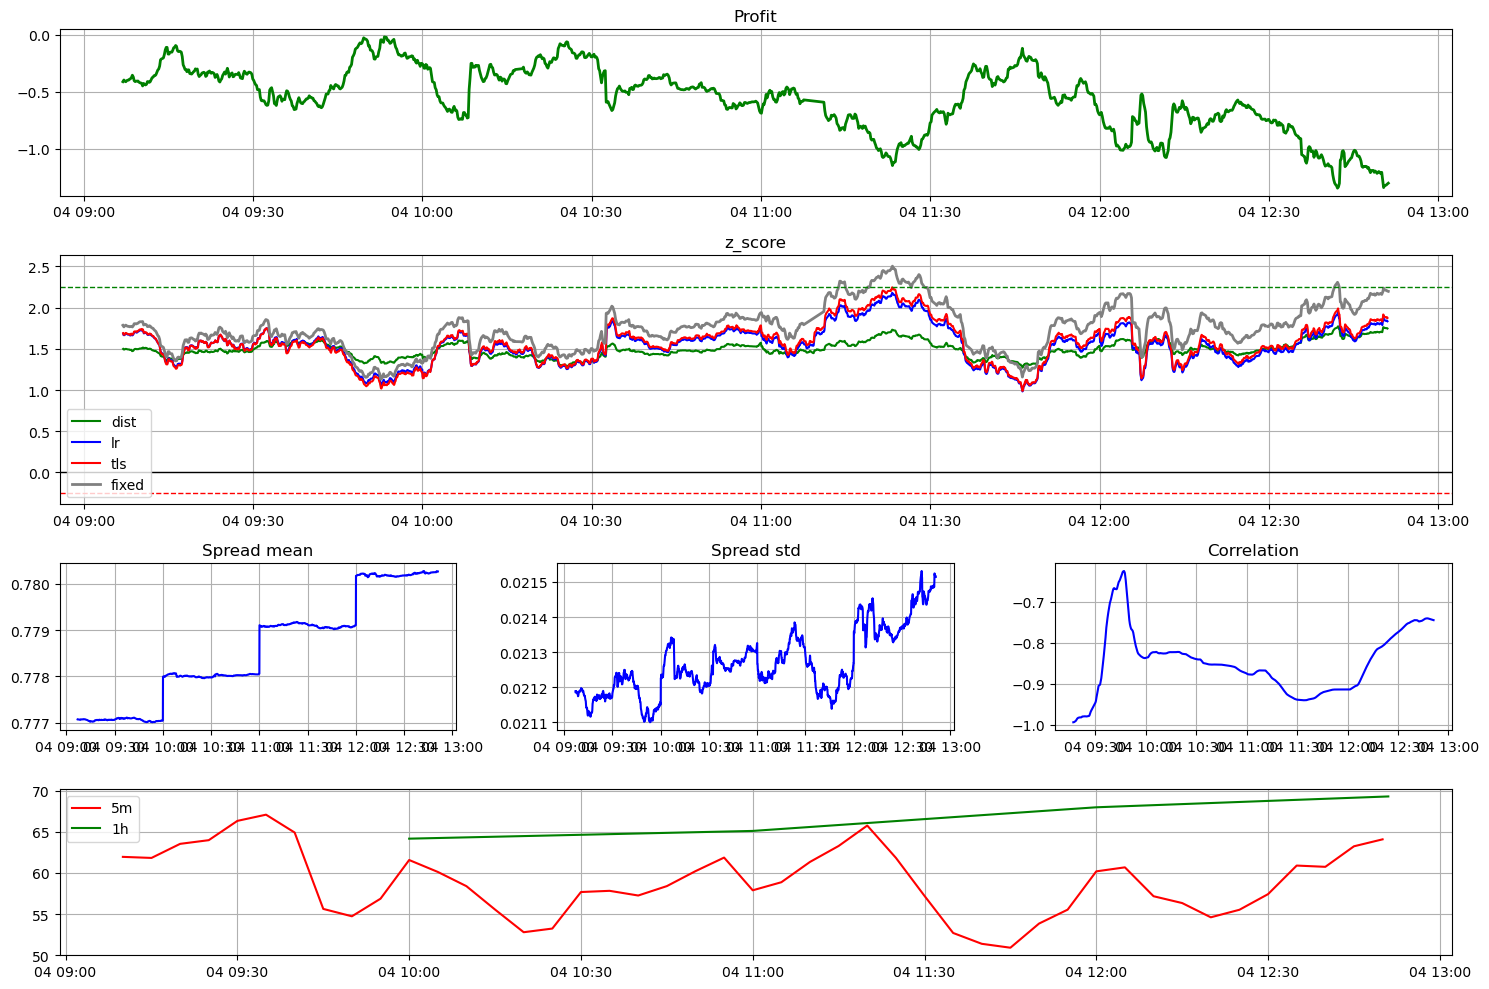

In [51]:
token_1 = 'INJ'
token_2 = 'PENDLE'
tick_df, agg_df, hist_zscore, lr_df = create_report(token_1, token_2)

In [ ]:
# switch_pairs('real', 'IOTA_USDT', 'MANTA_USDT', 'CELO_USDT', coin_information, db_manager)

In [25]:
pairs = db_manager.get_table('pairs', df_type='polars')
pairs.select('token_1', 'token_2', 'created_at', 'side_1', 'qty_1', 'qty_2', 'usdt_1', 'usdt_2',
            'rpnl_1', 'rpnl_2', 'upnl_1', 'upnl_2', 'profit_1', 'profit_2', 'profit', 'status')

token_1,token_2,created_at,side_1,qty_1,qty_2,usdt_1,usdt_2,rpnl_1,rpnl_2,upnl_1,upnl_2,profit_1,profit_2,profit,status
str,str,"datetime[μs, Europe/Moscow]",str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""INJ_USDT""","""PENDLE_USDT""",2025-12-04 09:06:55 MSK,"""short""",16.4,37.0,49.1344,49.3765,-0.088389,-0.085521,-0.0668,-0.1055,-0.155189,-0.191021,-0.34621,"""active"""
"""ONDO_USDT""","""OP_USDT""",2025-12-03 22:01:25 MSK,"""long""",196.0,306.9,49.686,49.579695,-0.119365,-0.079061,-0.3322,-1.13553,-0.451565,-1.21459,-1.666155,"""active"""


In [ ]:
# db_manager.set_status_to_order('real', 'AERO_USDT', 'LDO_USDT', 'closing')

In [ ]:
# db_manager.delete_pair_order('real', 'AERO_USDT', 'LDO_USDT')

In [152]:
from bot.utils.pair_trading import get_lr_zscore, get_dist_zscore

token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [153]:
tf = '1h'
wind = 64
td = int(tf[0]) * wind * 2 + 1

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
start_time = end_time - timedelta(hours = td)
hist_df = db_manager.get_orderbooks(interval=tf, start_date=start_time)
hist_df = hist_df.with_columns(pl.col('price').alias('avg_price'))

current_data = db_manager.get_table('current_ob', df_type='polars')
current_data = current_data.with_columns(
                    ((pl.col('bid_price_0') + pl.col('ask_price_0')) / 2.0).alias('avg_price')
                )
end_t = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
st_t = end_t - timedelta(seconds = 20)

tick_df = db_manager.get_tick_ob(start_time=st_t).with_columns(
    ((pl.col('bid_price') + pl.col('ask_price')) / 2.0).alias('avg_price')
)

for t1_name, t2_name in token_pairs:
    token_1 = t1_name + '_USDT'
    token_2 = t2_name + '_USDT'
    z_score = 0

    t1_tick_df = tick_df.filter(pl.col('token') == token_1)
    t2_tick_df = tick_df.filter(pl.col('token') == token_2)
    
    token_1_hist_price = hist_df.filter(pl.col('token') == token_1).tail(td)['avg_price'].to_numpy()
    token_2_hist_price = hist_df.filter(pl.col('token') == token_2).tail(td)['avg_price'].to_numpy()    
    t1_med = np.append(token_1_hist_price, t1_tick_df['avg_price'].median())
    t2_med = np.append(token_2_hist_price, t2_tick_df['avg_price'].median())
    
    _, _, _, zscore = get_dist_zscore(t1_med, t2_med, np.array([wind]))
    spr, spr_mean, spr_std, alpha, lr_beta, lr_zscore = get_lr_zscore(t1_med, t2_med, np.array([wind]))
    spr, spr_mean, spr_std, alpha, tls_beta, tls_zscore = get_tls_zscore(t1_med, t2_med, np.array([wind]))
    z_score = zscore[0]
    lr_zscore = lr_zscore[0]
    tls_zscore = tls_zscore[0]

    print(f'{token_1[:-5]:>7} - {token_2[:-5]:7}: dist: {z_score:5.2f}; lr: {lr_zscore:5.2f}; tls: {tls_zscore:5.2f}')

   AERO - ARB    : dist:  2.51; lr:  2.36; tls:  2.32
   AERO - ENA    : dist:  0.53; lr:  1.70; tls:  1.49
   AERO - LDO    : dist:  2.33; lr:  1.69; tls:  2.19
   AERO - PENDLE : dist:  2.25; lr:  2.43; tls:  2.60
    APT - ATOM   : dist:  1.06; lr:  0.28; tls:  1.14
    ARB - CELO   : dist: -0.15; lr:  0.51; tls: -0.02
   ATOM - PENDLE : dist: -0.44; lr:  0.14; tls: -0.81
   ATOM - TON    : dist: -0.87; lr: -0.10; tls: -1.04
    CRV - DYDX   : dist:  1.09; lr:  0.84; tls:  0.78
    CRV - LDO    : dist:  0.67; lr:  0.92; tls:  1.14
    DOT - PENDLE : dist:  1.26; lr:  1.47; tls:  1.87
  DRIFT - EIGEN  : dist: -0.19; lr:  0.39; tls:  0.12
  DRIFT - OP     : dist: -1.23; lr: -0.25; tls: -1.12
  EIGEN - OP     : dist: -0.93; lr: -0.93; tls: -1.61
  EIGEN - PENDLE : dist:  0.66; lr:  0.99; tls:  1.25
  EIGEN - SPX    : dist:  0.66; lr:  0.60; tls:  0.64
   FLOW - HBAR   : dist:  0.97; lr:  0.59; tls:  1.01
    IMX - JUP    : dist: -0.85; lr: -0.72; tls: -1.23
    IMX - XTZ    : dist: -1.

In [32]:
z = -1.77
th_in = 1.8
width = 0.1

In [33]:
th_in - width

1.7

In [11]:
db_manager.get_table('stop_list')

,token_1,token_2,created_at


In [138]:
tf = '1h'
wind = 64
winds = np.array([wind,])

token_1 = 'AERO'
token_2 = 'LDO'
token_3 = 'ARB'
token_4 = 'PENDLE'
min_order = 42

valid_length = 0
train_length = 6

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_3 = db_manager.get_tick_ob(token=token_3 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_4 = db_manager.get_tick_ob(token=token_4 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)

print(f'{token_1:>8} first date: {df_1['time'][0]}')
print(f'{token_2:>8} first date: {df_2['time'][0]}')
print(f'{token_3:>8} first date: {df_3['time'][0]}')
print(f'{token_4:>8} first date: {df_4['time'][0]}')

tick_df_aero_ldo = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
tick_df_aero_arb = make_df_from_orderbooks(df_1, df_3, token_1, token_3, start_time=start_time)
tick_df_aero_pendle = make_df_from_orderbooks(df_1, df_4, token_1, token_4, start_time=start_time)

agg_df_aero_ldo = make_trunc_df(tick_df_aero_ldo, tf, token_1, token_2, method='triple')
lr_aero_ldo = create_zscore_df(token_1, token_2, tick_df_aero_ldo, agg_df_aero_ldo, tf, winds, start_ts, 
                                 median_length=6, spr_method='lr')


agg_df_aero_arb = make_trunc_df(tick_df_aero_arb, tf, token_1, token_3, method='triple')
lr_aero_arb = create_zscore_df(token_1, token_3, tick_df_aero_arb, agg_df_aero_arb, tf, winds, start_ts, 
                                 median_length=6, spr_method='lr')

agg_df_aero_pendle = make_trunc_df(tick_df_aero_pendle, tf, token_1, token_4, method='triple')
lr_aero_pendle = create_zscore_df(token_1, token_4, tick_df_aero_pendle, agg_df_aero_pendle, tf, winds, start_ts, 
                                 median_length=6, spr_method='lr')


    AERO first date: 2025-11-28 00:00:00+03:00
     LDO first date: 2025-11-28 00:00:00+03:00
     ARB first date: 2025-11-28 00:00:00+03:00
  PENDLE first date: 2025-11-28 00:00:00+03:00


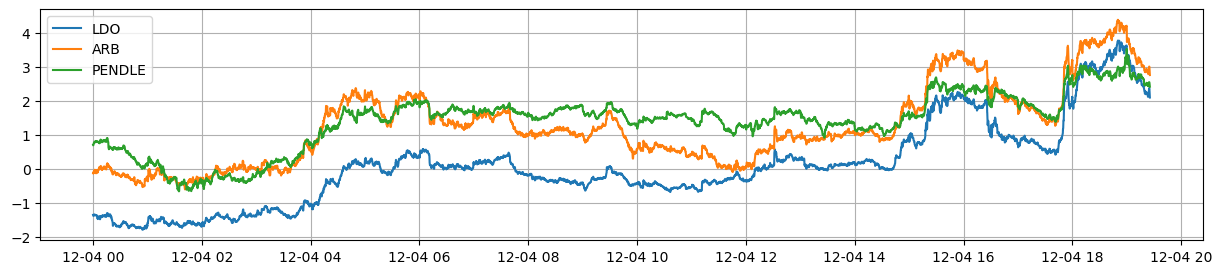

In [139]:
plt.figure(figsize=(15, 3))
plt.plot(lr_aero_ldo['time'], lr_aero_ldo[f'z_score_{wind}_{tf}'], label='LDO');
plt.plot(lr_aero_arb['time'], lr_aero_arb[f'z_score_{wind}_{tf}'], label='ARB');
plt.plot(lr_aero_pendle['time'], lr_aero_pendle[f'z_score_{wind}_{tf}'], label='PENDLE');

plt.legend()
plt.grid();